In [1]:
import argparse
import os, sys
from utils.data_utils import *
from glob import glob
import pandas as pd
import numpy as np
import shutil
from tqdm import tqdm
%matplotlib inline  
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12,9]
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.colheader_justify', 'left')

In [2]:
def is_windows():
    return sys.platform == 'win32'

In [3]:
res_dir = os.path.join('predictions')
if is_windows():
    l_dirs = ['0.21', '0.22', '0.23', '0.24', '0.25']
else:
    l_dirs = ['0.09']

In [4]:
train_augmented = True
valid_augmented = True

In [5]:
def get_data_dir(a, t):
    if t:
        if a:
            data_dir = 'train_ex'
        else:
            data_dir = 'train'
    else:
        if a:
            data_dir = 'valid_ex'
        else:
            data_dir = 'valid'
    return data_dir

def load_loss_df(l_dirs, augmented=False, train=False):
    data_dir = get_data_dir(augmented, train)
    dataframes = []
    for d in l_dirs:
        dataframes.append(pd.read_csv(os.path.join(res_dir, data_dir, d, 'models.csv')))

    df_l = pd.concat(dataframes, ignore_index=True)
    return df_l

def get_gt_name(a, t):
    if t:
        if a:
            name = 'Y_train_augmented.npz'
        else:
            name = 'Y_train.npz'
    else:
        if a:
            name = 'Y_valid_augmented.npz'
        else:
            name = 'Y_valid.npz'
    return name

def load_ground_truth(data_dir, augmented=False, train=False):
    gt_name = get_gt_name(augmented, train)
    y_true_path = os.path.join('augmented', data_dir, gt_name)
    y_true = npz_to_ndarray(np.load(y_true_path))
    return y_true

def load_preds(df_loss):
    preds = []
    for npz_path in df_loss.res_path:
        p = npz_to_ndarray(np.load(npz_path))
        preds.append(p)
    return np.array(preds)

def load_test_df(l_dirs):
    dataframes = []
    for d in l_dirs:
        dataframes.append(pd.read_csv(os.path.join('test_predictions', d, 'models.csv')))

    df_l = pd.concat(dataframes, ignore_index=True)
    return df_l

In [38]:
# min_score = 0.922
df_loss_valid = load_loss_df(l_dirs, augmented=valid_augmented, train=False)
# df_loss_valid = df_loss_valid_orig[df_loss_valid_orig.score > min_score]
len(df_loss_valid)

472

In [7]:
# df_loss_train = load_loss_df(l_dirs, augmented=train_augmented, train=True)
# len(df_loss_train)

In [34]:
df_test_predictions = load_test_df(l_dirs)
len(df_test_predictions)

17

In [39]:
preds_valid = load_preds(df_loss_valid)
preds_valid.shape

(472, 64768, 17)

In [35]:
preds_test = load_preds(df_test_predictions)
preds_test.shape

(17, 61191, 17)

In [11]:
# preds_train = load_preds(df_loss_train)
# preds_train.shape

In [12]:
y_true_valid = load_ground_truth('train_augmented_size_128_mult_8_seed_0', augmented=valid_augmented, train=False)
y_true_valid.shape

(64768, 17)

In [13]:
# y_true_train = load_ground_truth('train_augmented_size_128_mult_8_seed_0', augmented=train_augmented, train=True)
# y_true_train.shape

In [41]:
best_model = df_loss_valid.score.argmax()
print("Model with best score is %d where score is %f" % (best_model, df_loss_valid.score[best_model]))
print(df_loss_valid.model[best_model])

Model with best score is 435 where score is 0.928023
resnet50_1_23_0.09


In [15]:
# best_model_train = df_loss_train.score.argmax()
# print("Model with best score on training set is %d where score is %f" % (best_model_train, df_loss_train.score[best_model_train]))
# print(df_loss_train.model[best_model_train])

In [40]:
def calc_scores(preds, y_true):
    avg_pred = (np.mean(preds, axis=0) > 0.2).astype(int)
    vote_pred = (np.mean((np.array(preds) > 0.2).astype(int), axis=0) > 0.5).astype(int)
    avg_score = fbeta_score(y_true, avg_pred, beta=2, average='samples')
    vote_score = fbeta_score(y_true, vote_pred, beta=2, average='samples')
    mean_score = (avg_score+vote_score)/2
    return avg_score, vote_score, mean_score

def get_ensemble_scores(ensemble, all_preds, y_true):
    ensemble_preds = [all_preds[j] for j in ensemble]
    avg_score, vote_score, mean_score = calc_scores(ensemble_preds, y_true)
    return avg_score, vote_score

def find_best_candidate(y_true, all_preds, ensemble, opt_type = 'avg', exclude = []):
    best_avg_score = 0
    best_vote_score = 0
    best_mean_score = 0
    best_candidate = -1
    ensemble_preds = [all_preds[j] for j in ensemble]
    for i in tqdm(range(len(all_preds))):
        if i not in exclude:
            preds = ensemble_preds + [all_preds[i]]
            avg_pred = (np.mean(preds, axis=0) > 0.2).astype(int)
            avg_score = fbeta_score(y_true, avg_pred, beta=2, average='samples')
            if avg_score > best_avg_score:
                best_avg_score = avg_score                
                best_candidate = i          
                
    return best_candidate, best_avg_score, best_vote_score

In [20]:
def optimize_score_target(y_true_valid, preds_valid, init_ensemble = [], exclude = []):
    best_ensemble = init_ensemble[:]
    y_target = y_true_valid
    preds_target = preds_valid

    best_score = 0
    valid_scores = []
    counter = 0
    while True:
        best_candidate, avg_score, vote_score = \
            find_best_candidate(y_target, preds_target, ensemble=best_ensemble, exclude=exclude)
        sys.stdout.flush()
    
        score = avg_score
            
        if score > best_score:
            best_ensemble.append(best_candidate)
            print("%d: Best candidate model is %d with improvement of %.5f" % (counter, best_candidate, score-best_score))
            print("%d: Best ensemble %s" % (counter, best_ensemble))
            valid_scores.append(get_ensemble_scores(best_ensemble, preds_valid, y_true_valid)[0])
            print("%d: Ensemble valid score %.5f" % (counter, valid_scores[-1]))
            best_score = score
            counter+=1
        else:
            print("Can't optimize any more")
            break
    
    return best_ensemble, best_score, valid_scores

def val_idx_to_test(val_idx, df_test, df_valid):
    res = df_test[df_test.path.isin(df_valid.loc[val_idx].path)].index
    if len(res) != len(val_idx):
        raise RuntimeError("Some of the indexes not in the test dataframe")
        
    return res

def get_labels():
    labels = [
        'slash_burn',
        'clear',
        'blooming',
        'primary',
        'cloudy',
        'conventional_mine',
        'water',
        'haze',
        'cultivation',
        'partly_cloudy',
        'artisinal_mine',
        'habitation',
        'bare_ground',
        'blow_down',
        'agriculture',
        'road',
        'selective_logging'
    ]

    l_map = {l: i for i, l in enumerate(labels)}
    inv_map = {i: l for l, i in l_map.items()}
    return labels, l_map, inv_map

labels, label_map, inv_label_map = get_labels()

def to_tagging(one_hot_data, inv_label_map):
    res = pd.DataFrame(index=range(len(one_hot_data)), columns=['tags'])
    for j in range(len(one_hot_data)):
        tags = []
        for i in range(17):
            if one_hot_data[j][i] == 1:
                tags.append(inv_label_map[i])
        res['tags'][j] = ' '.join(sorted(tags))
    return res

def get_test_df():
    inputs_dir = 'inputs'
    df_submission = pd.read_csv(os.path.join(inputs_dir, 'sample_submission_v2.csv'))
    return df_submission

def create_submission(pred, sufix):
    print("Reading submission dataframe")
    df_submission = get_test_df()
    print("Creating tags")
    p_tags = to_tagging(pred, inv_label_map)
    df_submission.tags = p_tags.tags
    submission_dir = os.path.join('submissions', 'ensemble_avg_test')
    if not os.path.exists(submission_dir):
        os.makedirs(submission_dir)
        
    file_name = 'submission_' + sufix + '.csv'
    print("Saving submission to file")
    df_submission.to_csv(os.path.join(submission_dir, file_name), index=False)
    print("%s created" % os.path.join(submission_dir, file_name))

  0%|          | 0/472 [00:00<?, ?it/s]

0: Best candidate model is 435 with improvement of 0.92802
0: Best ensemble [435]
0: Ensemble valid score 0.92802


  0%|          | 0/472 [00:00<?, ?it/s]

1: Best candidate model is 110 with improvement of 0.00276
1: Best ensemble [435, 110]
1: Ensemble valid score 0.93078


  0%|          | 0/472 [00:00<?, ?it/s]

2: Best candidate model is 408 with improvement of 0.00074
2: Best ensemble [435, 110, 408]
2: Ensemble valid score 0.93152


  0%|          | 0/472 [00:00<?, ?it/s]

3: Best candidate model is 339 with improvement of 0.00067
3: Best ensemble [435, 110, 408, 339]
3: Ensemble valid score 0.93219


  0%|          | 0/472 [00:00<?, ?it/s]

4: Best candidate model is 59 with improvement of 0.00037
4: Best ensemble [435, 110, 408, 339, 59]
4: Ensemble valid score 0.93256


  0%|          | 0/472 [00:00<?, ?it/s]

5: Best candidate model is 400 with improvement of 0.00017
5: Best ensemble [435, 110, 408, 339, 59, 400]
5: Ensemble valid score 0.93273


100%|██████████| 472/472 [00:38<00:00, 12.17it/s]


6: Best candidate model is 435 with improvement of 0.00016
6: Best ensemble [435, 110, 408, 339, 59, 400, 435]


  0%|          | 2/472 [00:00<00:42, 11.06it/s]

6: Ensemble valid score 0.93290


  0%|          | 0/472 [00:00<?, ?it/s]

7: Best candidate model is 112 with improvement of 0.00003
7: Best ensemble [435, 110, 408, 339, 59, 400, 435, 112]
7: Ensemble valid score 0.93293


100%|██████████| 472/472 [00:39<00:00, 11.92it/s]


8: Best candidate model is 141 with improvement of 0.00006
8: Best ensemble [435, 110, 408, 339, 59, 400, 435, 112, 141]


  0%|          | 1/472 [00:00<01:11,  6.54it/s]

8: Ensemble valid score 0.93299


100%|██████████| 472/472 [00:42<00:00, 10.98it/s]


9: Best candidate model is 454 with improvement of 0.00022
9: Best ensemble [435, 110, 408, 339, 59, 400, 435, 112, 141, 454]


  0%|          | 2/472 [00:00<00:40, 11.60it/s]

9: Ensemble valid score 0.93322


100%|██████████| 472/472 [00:42<00:00, 11.30it/s]


Can't optimize any more
[435, 110, 408, 339, 59, 400, 435, 112, 141, 454]
0.933215722643
Ensemble valid score 0.93322


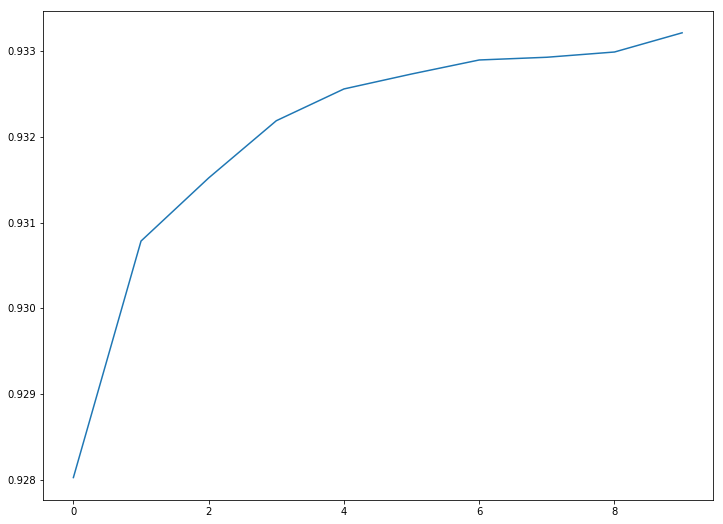

In [42]:
best_avg_ensemble, best_score, valid_scores = optimize_score_target(y_true_valid, preds_valid)
print(best_avg_ensemble)
print(best_score)
# print("Ensemble train score %.5f" % get_ensemble_scores(best_avg_ensemble, preds_train, y_true_train)[0])
print("Ensemble valid score %.5f" % get_ensemble_scores(best_avg_ensemble, preds_valid, y_true_valid)[0])
# plt.plot(train_scores)
plt.plot(valid_scores)

In [43]:
print("Ensemble size %s" % len(best_avg_ensemble))
df_loss_valid.loc[best_avg_ensemble]

Ensemble size 10


,epoch,loss,model,model_name,path,res_path,score
435,23.0,0.09,resnet50_1_23_0.09,resnet50_1,models/resnet50_1_256_binary_crossentropy_rmsprop_synt_medium_good/resnet50_1_23_0.09.h5,predictions/valid_ex/0.09/resnet50_1_256_binary_crossentropy_rmsprop_synt_medium_good_resnet50_1...,0.928023
110,34.0,0.09,net1_34_0.09,net1,models/net1_128_binary_crossentropy_rmsprop_ed/net1_34_0.09.h5,predictions/valid_ex/0.09/net1_128_binary_crossentropy_rmsprop_ed_net1_34_0.09.npz,0.925849
408,37.0,0.09,inceptionV3_1_37_0.09,inceptionV3_1,models/inceptionV3_1_256_binary_crossentropy_rmsprop_synt_medium/inceptionV3_1_37_0.09.h5,predictions/valid_ex/0.09/inceptionV3_1_256_binary_crossentropy_rmsprop_synt_medium_inceptionV3_...,0.922666
339,25.0,0.09,xception6_25_0.09,xception6,models/xception6_256_binary_crossentropy_rmsprop_synt_medium/xception6_25_0.09.h5,predictions/valid_ex/0.09/xception6_256_binary_crossentropy_rmsprop_synt_medium_xception6_25_0.0...,0.924762
59,30.0,0.09,inception2_30_0.09,inception2,models/inception2_128_binary_crossentropy_rmsprop/inception2_30_0.09.h5,predictions/valid_ex/0.09/inception2_128_binary_crossentropy_rmsprop_inception2_30_0.09.npz,0.922770
400,22.0,0.09,inceptionV3_0_22_0.09,inceptionV3_0,models/inceptionV3_0_256_binary_crossentropy_rmsprop_synt_medium/inceptionV3_0_22_0.09.h5,predictions/valid_ex/0.09/inceptionV3_0_256_binary_crossentropy_rmsprop_synt_medium_inceptionV3_...,0.925353
435,23.0,0.09,resnet50_1_23_0.09,resnet50_1,models/resnet50_1_256_binary_crossentropy_rmsprop_synt_medium_good/resnet50_1_23_0.09.h5,predictions/valid_ex/0.09/resnet50_1_256_binary_crossentropy_rmsprop_synt_medium_good_resnet50_1...,0.928023
112,20.0,0.09,net1_20_0.09,net1,models/net1_128_binary_crossentropy_rmsprop_ed/net1_20_0.09.h5,predictions/valid_ex/0.09/net1_128_binary_crossentropy_rmsprop_ed_net1_20_0.09.npz,0.923111
141,12.0,0.09,vgg16_1_12_0.09,vgg16_1,models/vgg16_1_128_binary_crossentropy_rmsprop/vgg16_1_12_0.09.h5,predictions/valid_ex/0.09/vgg16_1_128_binary_crossentropy_rmsprop_vgg16_1_12_0.09.npz,0.920056
454,30.0,0.09,resnet50_0_30_0.09,resnet50_0,models/resnet50_0_256_binary_crossentropy_rmsprop_synt_medium/resnet50_0_30_0.09.h5,predictions/valid_ex/0.09/resnet50_0_256_binary_crossentropy_rmsprop_synt_medium_resnet50_0_30_0...,0.924878


In [44]:
df_ensemble = df_loss_valid.loc[best_avg_ensemble]
df_ensemble.to_csv('best_ensemble.csv', index=False)

In [37]:
print(best_avg_ensemble)
test_idx = val_idx_to_test(best_avg_ensemble, df_test=df_test_predictions, df_valid=df_loss_valid)
print(list(test_idx))
preds_for_submission = preds_test[test_idx]
print(preds_for_submission.shape)
pred_test = np.mean(preds_for_submission, axis=0)
pred_test_final = (pred_test>0.2).astype(int)
create_submission(pred_test_final, '_val_loss_0.93360')

[435, 110, 408, 339, 59, 400, 435, 112, 141, 336, 138, 395, 367, 112, 177, 138, 382]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
(17, 61191, 17)
Reading submission dataframe
Creating tags
Saving submission to file
submissions/ensemble_avg_test/submission__val_loss_0.93360.csv created


In [94]:
# new_ensemble = best_avg_ensemble[:]
# new_ensemble.remove(138)
# print("Ensemble score %.5f" % get_ensemble_scores(new_ensemble, preds_valid, y_true_valid)[0])

In [95]:
# ens, bs, vs = optimize_score_target(y_true_valid, preds_valid, init_ensemble=new_ensemble)
# print(ens)
# print(bs)
# # print("Ensemble train score %.5f" % get_ensemble_scores(best_avg_ensemble, preds_train, y_true_train)[0])
# print("Ensemble valid score %.5f" % get_ensemble_scores(ens, preds_valid, y_true_valid)[0])
# # plt.plot(train_scores)
# plt.plot(vs)

In [78]:
preds_for_submission = preds_test[test_idx]
print(preds_for_submission.shape)
pred_test = np.mean(preds_for_submission, axis=0)
pred_test_final = (pred_test>0.2).astype(int)
create_submission(pred_test_final, '_val_loss_0.93280')

(8, 61191, 17)
Reading submission dataframe
Creating tags
Saving submission to file
submissions/ensemble_avg_test/submission__val_loss_0.93280.csv created


In [63]:
import shutil
ensemble_dir = os.path.join('other_models', 'ensembles_avg')
if not os.path.exists(ensemble_dir):
    os.makedirs(ensemble_dir)

print(my_ensemble)
print(best_score)
csv_name = "ensemble2_val_score_%.5f.csv" % best_score
df_loss_valid.loc[my_ensemble].to_csv(os.path.join(ensemble_dir, csv_name), index=False)

print("Done")

[110, 58, 108, 13, 132, 94, 51, 112, 22, 89, 68, 119, 117, 93, 125]
0.930605228728
Done


In [ ]:
import shutil
copy_to = os.path.join('other_models', 'ensemble20')
if not os.path.exists(copy_to):
    os.makedirs(copy_to)
for j, i in enumerate(my_ensemble):
    m = df_loss_valid.loc[i].path
    dest = os.path.join(copy_to, df_loss_valid.loc[i].model + '.h5')
    shutil.copyfile(m, dest)
print("Done")

Mean bias of validation vs LB 0.00080


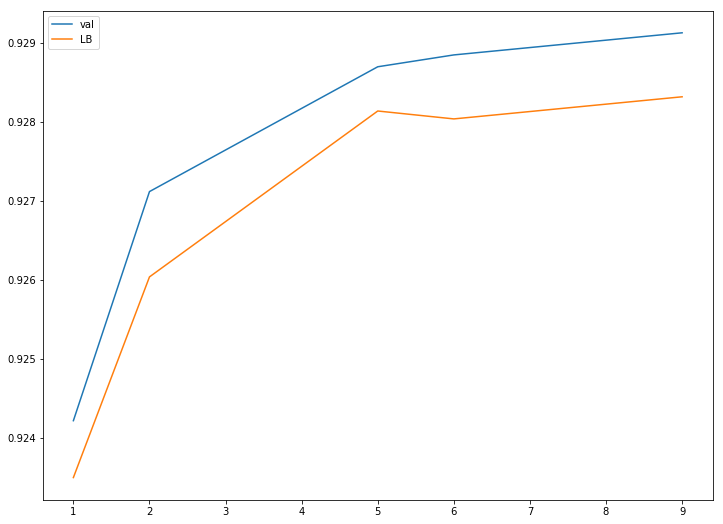

In [37]:
x = [1,2,5,6,9]
val_score = [0.92422, 0.92712, 0.92870, 0.92885, 0.92913]
lb_score = [0.92350, 0.92604, 0.92814, 0.92804, 0.92832]
print("Mean bias of validation vs LB %.5f" % (np.array(val_score) - np.array(lb_score)).mean())
plt.plot(x, val_score)
plt.plot(x, lb_score)
plt.legend(labels=['val', 'LB'])